#   LangGraph 활용 - Self RAG 

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

import warnings
warnings.filterwarnings("ignore")

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true  # 모니터링 활성화할꺼냐


---

## **Self-RAG**

- Self-RAG (Retrieval-Augmented Generation with Self-Reflection) 

- 주요 단계: 

   1. 검색 결정 (Retrieval Decision):
      - 입력: 질문 `x` 또는 질문 `x`와 생성된 답변 `y`
      - 목적: 검색기 `R`을 사용하여 `D` 개의 청크를 검색할지 결정
      - 출력: "yes", "no", "continue" 중 하나
      - 의미: 시스템이 추가 정보가 필요한지 판단

   2. 검색된 문서 관련성 평가:
      - 입력: 질문 `x`와 각 검색된 청크 `d`
      - 목적: 각 청크가 질문에 유용한 정보를 제공하는지 평가
      - 출력: "relevant" 또는 "irrelevant"
      - 의미: 관련 없는 정보를 필터링하여 품질을 향상

   3. 생성된 답변의 환각 평가:
      - 입력: 질문 `x`, 청크 `d`, 생성된 텍스트 `y`
      - 목적: 생성된 텍스트가 청크의 정보에 의해 지지되는지 평가
      - 출력: "fully supported", "partially supported", "no support"
      - 의미: 환각(hallucination)을 감지하고 정보의 신뢰성을 확인

   4. 생성된 답변의 유용성 평가:
      - 입력: 질문 `x`와 생성된 텍스트 `y`
      - 목적: 생성된 텍스트가 질문에 유용한 응답인지 평가
      - 출력: 5점 척도 (5: 매우 유용, 1: 전혀 유용하지 않음)
      - 의미: 응답의 품질과 관련성을 수치화

- 논문: https://arxiv.org/abs/2310.11511

### **1. 벡터저장소** 
- 메뉴 검색을 위해 저장해둔 저장소를 로드

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

In [5]:
# 검색기 생성 
retriever= vector_db.as_retriever(search_kwargs={"k":3})

# 검색 테스트
query = "스테이크와 어울리는 와인을 추천해주세요."
results = retriever.invoke(query)

pprint(results)

[Document(id='c2fee3d9-20c0-4462-b722-0c7a6c6e0dd9', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '안심 스테이크 샐러드', 'menu_number': 8}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.'),
 Document(id='51216860-ab2c-4aad-a72a-9e57737042cd', metadata={'menu_number': 7, 'menu_name': '랍스터 비스크', 'source': './data/restaurant_menu.txt'}, page_content='7. 랍스터 비스크\n   • 가격: ₩28,000\n   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카\n   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.'),
 Document(id='d09e51d7-b4f7-4c31-ba99-7c8022b732d7', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '시그니처 스테이크', 'menu_number': 1}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심

### **2. Retrieval Grader** 

- 검색 평가자는 **키워드 관련성**과 **의미적 관련성**을 기준으로 결과를 평가

- 평가는 **'yes/no' 이진법**으로 진행하며 불확실한 경우 'no' 처리

- 부분 관련성이나 맥락 정보도 **답변 형성 기여도** 기준으로 평가

`(1) 데이터 모델 및 LLM 초기화`

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from pydantic import BaseModel, Field
from typing import Literal


# 검색된 문서의 관련성 평가 결과를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: Literal['yes', 'no'] = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments) # 구조화된 출력

`(2) LCEL 체인 구성`

In [7]:
# 문서 관련성 평가를 위한 시스템 프롬프트 정의
system_prompt = """당신은 사용자 질문에 대한 검색 결과의 관련성을 평가하는 전문가입니다.

평가 기준:
1. 키워드 관련성: 문서가 질문의 주요 단어나 유사어를 포함하는지 확인
2. 의미적 관련성: 문서의 전반적인 주제가 질문의 의도와 일치하는지 평가
3. 부분 관련성: 질문의 일부를 다루거나 맥락 정보를 제공하는 문서도 고려
4. 답변 가능성: 직접적인 답이 아니더라도 답변 형성에 도움될 정보 포함 여부 평가

점수 체계:
- 관련 있으면 'yes', 없으면 'no'로 평가
- 확실하지 않은 경우 'no'로 평가하여 불포함 쪽으로 결정

주의사항:
- 단순 단어 매칭이 아닌 질문의 전체 맥락을 고려하세요
- 완벽한 답변이 아니어도 유용한 정보가 있다면 관련 있다고 판단하세요

당신의 평가는 정보 검색 시스템 개선에 중요합니다. 균형 잡힌 평가를 해주세요."""

human_prompt = """
다음 문서가 사용자 질문에 관련 있는지 평가해주세요.

[Retrieved document]
{document}

[User question]
{question}

[Grade the relevance of the retrieved document]
"""

# 채점 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", human_prompt),
])


# Retrieval Grader 파이프라인 구성
retrieval_grader = grade_prompt | structured_llm_grader

`(3) 평가 수행`

In [8]:
# 관련성 평가 실행
question = "이 식당을 대표하는 메뉴는 무엇인가요?"
retrieved_docs = vector_db.similarity_search(question, k=2)
print(f"검색된 문서 수: {len(retrieved_docs)}")
print("===============================================================================")
print()


relevant_docs = []

for doc in retrieved_docs:
    print("문서:", doc.page_content)
    print("---------------------------------------------------------------------------")

    relevance = retrieval_grader.invoke(
        input={"question": question, "document": doc}
        )
    print(f"문서 관련성: {relevance}")

    if relevance.binary_score == 'yes':
        relevant_docs.append(doc)
    
    print("===========================================================================")

검색된 문서 수: 2

문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
---------------------------------------------------------------------------
문서 관련성: binary_score='yes'
문서: 3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.
---------------------------------------------------------------------------
문서 관련성: binary_score='no'


### **3. Answer Generator** 

- **답변 생성** 시 문맥 내 정보만 사용하고 추측 배제
- 답변은 **직접 관련 정보**만 포함하여 간결하게 작성
- 정보 부족 시 "**주어진 정보만으로는 답할 수 없습니다**" 명시
- 필요시 **직접 인용문** 활용하여 정확성 확보

In [9]:
# 기본 RAG 체인
from langchain_core.output_parsers import StrOutputParser

def generator_answer(question, docs):

    template = """
    Answer the question based solely on the given context. Do not use any external information or knowledge.

    [Instructions]
        1. 질문과 관련된 정보를 문맥에서 신중하게 확인합니다.
        2. 답변에 질문과 직접 관련된 정보만 사용합니다.
        3. 문맥에 명시되지 않은 내용에 대해 추측하지 않습니다.
        4. 불필요한 정보를 피하고, 답변을 간결하고 명확하게 작성합니다.
        5. 문맥에서 답을 찾을 수 없으면 "주어진 정보만으로는 답할 수 없습니다."라고 답변합니다.
        6. 적절한 경우 문맥에서 직접 인용하며, 따옴표를 사용합니다.

    [Context]
    {context}

    [Question]
    {question}

    [Answer]
    """

    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)    

    def format_docs(docs):
        return "\n\n".join([d.page_content for d in docs])
    
    rag_chain = prompt | llm | StrOutputParser() # rag_chain 구성
    
    generation = rag_chain.invoke(
        {"context": format_docs(docs), "question": question}
        )

    return generation


# 관령성 평가를 통과한 문서를 기반으로 질문에 대한 답변 생성
generation = generator_answer(question, docs=relevant_docs)
print(generation)

시그니처 스테이크입니다.


### **4. Hallucination Grader** 

- **시스템 프롬프트**는 사실 기반 답변을 평가하는 전문가 역할을 정의함
- 평가는 **두 가지 기준**으로 진행: 사실 근거 시 'yes', 근거 부족 시 'no'

In [10]:
# 환각(Hallucination) 평가 결과를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations) # 구조화된 출력


# 환각 평가를 위한 시스템 프롬프트 정의
system_prompt = """
You are an expert evaluator assessing whether an LLM-generated answer is grounded in and supported by a given set of facts.

[Your task]
    - LLM이 생성한 답변을 검토합니다.
    - 답변이 주어진 사실로 완전히 뒷받침되는지 판단합니다.

[Evaluation criteria]
    - 답변에 주어진 사실이나 명확히 추론할 수 있는 정보 외의 내용이 없어야 합니다.
    - 답변의 모든 핵심 내용이 주어진 사실에서 비롯되어야 합니다.
    - 사실적 정확성에 집중하고, 글쓰기 스타일이나 완전성은 평가하지 않습니다.

[Scoring]
    - 'yes': 답변이 사실에 근거하고 완전히 지원되는 경우.
    - 'no': 답변에 사실에 근거하지 않은 정보나 주장이 포함된 경우.

Your evaluation is crucial in ensuring the reliability and factual accuracy of AI-generated responses. Be thorough and critical in your assessment.
"""

# 환각 평가 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "[Set of facts]\n{documents}\n\n[LLM generation]\n{generation}"),
    ]
)

# Hallucination Grader 파이프라인 구성
hallucination_grader = hallucination_prompt | structured_llm_grader

# 환각 평가 실행
hallucination = hallucination_grader.invoke(
    {"documents": relevant_docs, "generation": generation}  #  앞에 검색한 문서와(relevant_docs) 답변(generation) 전달
    )
print(f"환각 평가: {hallucination}")

환각 평가: binary_score='yes'


### **5. Answer Grader** 

- 답변 평가는 **정보 포함 여부**를 기준으로 'yes' 또는 'no'로 판단
- 시스템은 **단순명확한 기준**으로 답변의 적절성을 평가함

In [11]:
# 답변 평가 결과를 위한 데이터 모델 정의 - 구조화된 출력을 위한 클래스 생성
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer) # 구조화된 출력 

# 답변 평가를 위한 시스템 프롬프트 정의
system_prompt = """
You are an expert evaluator tasked with assessing whether an LLM-generated answer effectively addresses and resolves a user's question.

[Your task]
    - 사용자의 질문을 신중히 분석하여 핵심 의도와 요구 사항을 이해합니다.
    - LLM이 생성한 답변이 질문을 충분히 해결했는지 판단합니다.

[Evaluation criteria]
    - 관련성: 답변이 질문과 직접적으로 관련되어야 합니다.
    - 완전성: 질문의 모든 측면이 다뤄져야 합니다.
    - 정확성: 제공된 정보가 정확하고 최신이어야 합니다.
    - 명확성: 답변이 명확하고 이해하기 쉬워야 합니다.
    - 구체성: 질문의 요구 사항에 맞는 상세한 답변이어야 합니다.

[Scoring]
    - 'yes': 답변이 질문을 효과적으로 해결한 경우.
    - 'no': 답변이 질문을 충분히 해결하지 못하거나 중요한 요소가 부족한 경우.
    - 답변이 완벽하지 않아도 핵심 질문을 해결하면 'yes'를 줄 수 있습니다.
    - 부분적으로 맞지만 중요한 요소가 빠진 답변은 'no'로 평가합니다.

Your evaluation plays a critical role in ensuring the quality and effectiveness of AI-generated responses. Strive for balanced and thoughtful assessments.
"""


# 답변 평가 프롬프트 템플릿 생성
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "[User question]\n{question}\n\n[LLM generation]\n{generation}"),
    ]
)


# Answer Grader 파이프라인 구성
answer_grader = answer_prompt | structured_llm_grader

# 답변 평가 실행
print("Question:", question)
print("Generation:", generation)

answer_score = answer_grader.invoke(
    {"question": question, "generation": generation}
)
print(f"답변 평가: {answer_score}")

Question: 이 식당을 대표하는 메뉴는 무엇인가요?
Generation: 시그니처 스테이크입니다.
답변 평가: binary_score='yes'


### **6. Question Re-writer** 

- 질문을 **명확성과 간결성** 중심으로 개선하는 것이 주요 목표
- 불필요한 정보 제거 시에도 **원래 의도 유지**가 핵심 지침

In [12]:
def rewrite_question(question: str) -> str:
    """
    주어진 질문을 벡터 저장소 검색에 최적화된 형태로 다시 작성합니다.

    :param question: 원본 질문 문자열
    :return: 다시 작성된 질문 문자열
    """
    # LLM 모델 초기화
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

    # 시스템 프롬프트 정의
    system_prompt = """
    You are an expert question re-writer. Your task is to convert input questions into optimized versions 
    for vectorstore retrieval. Analyze the input carefully and focus on capturing the underlying semantic 
    intent and meaning. Your goal is to create a question that will lead to more effective and relevant 
    document retrieval.

    [Guidelines]
        1. 질문에서 핵심 개념과 주요 대상을 식별하고 강조합니다.
        2. 약어나 모호한 용어를 풀어서 사용합니다.
        3. 관련 문서에 등장할 수 있는 동의어나 연관된 용어를 포함합니다.
        4. 질문의 원래 의도와 범위를 유지합니다.
        5. 복잡한 질문은 간단하고 집중된 하위 질문으로 나눕니다.

    Remember, the goal is to improve retrieval effectiveness, not to change the fundamental meaning of the question.
    """

    # 질문 다시 쓰기 프롬프트 템플릿 생성
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            (
                "human",
                "[Initial question]\n{question}\n\n[Improved question]\n",
            ),
        ]
    )

    # 질문 다시 쓰기 체인 구성
    question_rewriter = re_write_prompt | llm | StrOutputParser()

    # 질문 다시 쓰기 실행
    rewritten_question = question_rewriter.invoke(
        {"question": question}
    )

    return rewritten_question

# 질문 다시 쓰기 테스트
rewritten_question = rewrite_question(question)
print(f"원본 질문: {question}")
print(f"다시 쓴 질문: {rewritten_question}")

원본 질문: 이 식당을 대표하는 메뉴는 무엇인가요?
다시 쓴 질문: 이 식당을 대표하는 인기 메뉴와 주요 요리 종류는 무엇인가요?


In [13]:
# 다시 쓴 질문을 사용하여 벡터 저장소에서 문서 검색
query = rewritten_question
retrieved_docs = vector_db.similarity_search(query, k=2)
print(len(retrieved_docs))
print("===========================================================================")

for doc in retrieved_docs:
    print("문서:", doc.page_content)
    print("---------------------------------------------------------------------------")

2
문서: 30. 씨푸드 빠에야
    • 가격: ₩42,000
    • 주요 식재료: 스페인산 봄바 쌀, 홍합, 새우, 오징어, 사프란
    • 설명: 스페인 전통 방식으로 조리한 해산물 빠에야입니다. 최상급 사프란으로 노란빛을 내고 신선한 해산물을 듬뿍 넣어 지중해의 맛을 그대로 담았습니다. 2인 이상 주문 가능하며 레몬을 곁들여 제공됩니다.
---------------------------------------------------------------------------
문서: 26. 샤토브리앙 스테이크
    • 가격: ₩42,000
    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스
    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.
---------------------------------------------------------------------------


### **7. LangGraph로 그래프 구현** 

- **LangGraph** 구현은 기본적인 StateGraph를 활용
- **Node와 Edge** 를 사용하여, 이전에 구현한 노드 함수를 연결

`(1) 그래프 State 생성`

In [14]:
from typing import List, TypedDict
from langchain_core.documents import Document

class GraphState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

`(2) Node 구성`

In [17]:
# Node 정의

def retrieve(state: GraphState) -> GraphState:
    """문서를 검색하는 함수"""
    print("--- 문서 검색 ---")
    question = state["question"]
    
    # 문서 검색 로직
    documents = vector_db.similarity_search(question)
    return {"documents": documents}      # 가장 마지막에 검색한 문서 객체들로 상태를 업데이트 

def generate(state: GraphState) -> GraphState:
    """답변을 생성하는 함수"""
    print("--- 답변 생성 ---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG를 이용한 답변 생성
    generation = generator_answer(question, docs=documents)

    # 생성 횟수 업데이트
    num_generations = state.get("num_generations", 0)
    num_generations += 1
    return {"generation": generation, "num_generations": num_generations}      # 답변, 생성횟수 업데이트 


def grade_documents(state: GraphState) -> GraphState:
    """검색된 문서의 관련성을 평가하는 함수"""
    print("--- 문서 관련성 평가 ---")
    question = state["question"]
    documents = state["documents"]
    
    # 각 문서 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d})
        grade = score.binary_score
        if grade == "yes":
            print("---문서 관련성: 있음---")
            filtered_docs.append(d)
        else:
            print("---문서 관련성: 없음---")
            
    return {"documents": filtered_docs}       # 관련성 평가에 합격한 문서들만 저장 (override)



def transform_query(state: GraphState) -> GraphState:
    """질문을 개선하는 함수"""
    print("--- 질문 개선 ---")
    question = state["question"]
    
    # 질문 재작성
    rewritten_question = rewrite_question(question)

    # 생성 횟수 업데이트
    num_generations = state.get("num_generations", 0)
    num_generations += 1
    return {"question": rewritten_question, "num_generations": num_generations}      # 재작성한 질문을 저장, 생성횟수 업데이트 

`(3) Edge 구성`

In [18]:
def decide_to_generate(state: GraphState) -> str:
    """답변 생성 여부를 결정하는 함수"""

    num_generations = state.get("num_generations", 0)
    if num_generations > 5:
        print("--- 결정: 생성 횟수 초과, 답변 생성 (-> generate)---")
        return "generate"

    
    print("--- 평가된 문서 분석 ---") 
    filtered_documents = state["documents"] 
    
    
    if not filtered_documents:
        print("--- 결정: 모든 문서가 질문과 관련이 없음, 질문 개선 필요 (-> transform_query)---")
        return "transform_query"
    else:
        print("--- 결정: 답변 생성 (-> generate)---")
        return "generate"

def grade_generation(state: GraphState) -> str:
    """생성된 답변의 품질을 평가하는 함수"""

    num_generations = state.get("num_generations", 0)
    if num_generations > 5:                             # 생성횟수가 5 이하라면 평가된 문서 가져오면 됨
        print("--- 결정: 생성 횟수 초과, 종료 (-> END)---")
        return "end"
    
    # 1단계: 환각 여부 확인
    print("--- 환각 여부 확인 ---")
    question, documents, generation = state["question"], state["documents"], state["generation"]
    
    
    # 체크 한번
    hallucination_grade = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # 체크 두번
    if hallucination_grade.binary_score == "yes":
        print("--- 결정: No 환각 (답변이 컨텍스트에 근거함) ---")

        # 1단계 통과할 경우 -> 2단계: 질문-답변 관련성 평가 
        print("---질문-답변 관련성 확인---")
        relevance_grade = answer_grader.invoke({"question": question, "generation": generation})
        if relevance_grade.binary_score == "yes":
            print("--- 결정: 생성된 답변이 질문을 잘 다룸 (-> END) ---")
            return "useful"
        else:
            print("--- 결정: 생성된 답변이 질문을 제대로 다루지 않음 (-> transform_query) ---")
            return "not useful"
    else:
        print("--- 결정: 생성된 답변이 문서에 근거하지 않음, 재시도 필요 (-> generate) ---")
        return "not supported"

`(4) 그래프 연결`

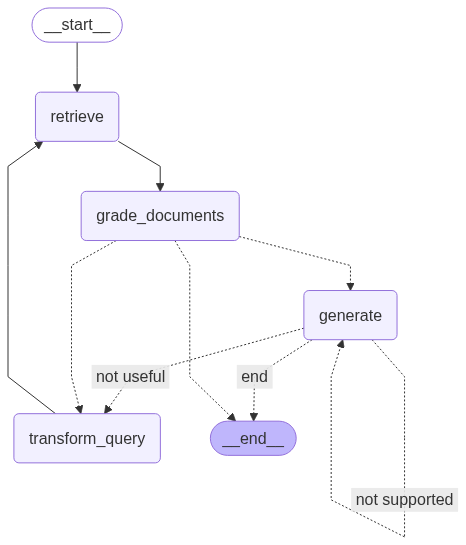

In [ ]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 워크플로우 그래프 초기화
builder = StateGraph(GraphState)

# 노드 정의
builder.add_node("retrieve", retrieve)                # 문서 검색
builder.add_node("grade_documents", grade_documents)  # 문서 평가
builder.add_node("generate", generate)                # 답변 생성
builder.add_node("transform_query", transform_query)  # 질문 개선

# 그래프 구축
builder.add_edge(START, "retrieve")             # 시작 -> 검색
builder.add_edge("retrieve", "grade_documents") # 검색 -> grade_documents

# 조건부 엣지 추가: 문서 평가 후 결정
builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
builder.add_edge("transform_query", "retrieve")

# 조건부 엣지 추가: 답변 생성 후 평가
builder.add_conditional_edges(
    "generate",
    grade_generation,
    {
        "not supported": "generate",          # 환각이 발생한 경우 -> 답변을 다시 생성 
        "not useful": "transform_query",      # 질문과 답변의 관련성이 부족한 경우 -> 쿼리 개선해서 다시 검색 
        "useful": END, 
        "end": END,
    },
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(5) 그래프 실행`

In [ ]:
inputs = {"question": "이 식당의 대표 메뉴는 무엇인가요? 주재료는 무엇인가요?"}
final_output = graph.invoke(inputs)

In [ ]:
# 최종 답변 
final_output["generation"]

In [ ]:
inputs = {"question": "김치찌개 메뉴가 있나요?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
# 최종 답변
print(value["generation"])

---
# **[실습]**

- State, Node, Edge를 직접 구성하여, Self-RAG 시스템을 개선합니다. 
- 그래프 구현을 통해 RAG 품질을 개선하는 과정을 이해합니다.

In [ ]:
# 여기에 코드를 작성하세요.